On February 22, 2000, after 11 days of measurements, the most comprehensive map ever created of the earth's topography was complete. The space shuttle *Endeavor* had just completed the Shuttle Radar Topography Mission, using a specialised radar to image the earths surface.

The Digital Elevation Map (DEM) produced by this mission is in the public domain and provides the measured terrain high at ~90 meter resolution. The mission mapped 99.98% of the area between 60 degrees North and 56 degrees South.  

In this post, I will examine how to process the raw DEM so it is more intuitively interpreted, through the use of *hillshading*,*slopeshading* & *hypsometric tinting*. 

The process of transforming the raw GeoTIFF into the final imagery product is simple. Much of the grunt work being carried out by GDAL, the Geospatial Data Abstraction Library. 

In order, we need to:

1. Download a DEM as a GeoTIFF
2. Extract a subsection of the GeoTIFF
3. Reproject the subsection
4. Make an image by hillshading
5. Make an image by coloring the subsection according to altitude
6. Make an image by coloring the subsection according to slope
7. Combine the 3 images into a final composite

DEM
====

Several different DEM's have been created from the data collected on the SRTM mission, in this post I will use the CGIAR [SRTM 90m Digital Elevation Database](http://www.cgiar-csi.org/data/srtm-90m-digital-elevation-database-v4-1). Data is provided in 5x5 degree tiles, with each degree of latitude equal to approximately 111Km. 

Our first task is to acquire a tile. Tiles can be downloaded from http://data.cgiar-csi.org/srtm/tiles/GeoTIFF/ using wget. 


In [37]:
import os
import math
from PIL import Image, ImageChops, ImageEnhance
from matplotlib import cm

In [38]:
def downloadDEMFromCGIAR(lat,lon):
    ''' Download a DEM from CGIAR FTP repository '''
    fileName = lonLatToFileName(lon,lat)+'.zip'

    ''' Check to see if we have already downloaded the file '''
    if fileName not in os.listdir('.'):
        os.system('''wget --user=data_public --password='GDdci' http://data.cgiar-csi.org/srtm/tiles/GeoTIFF/'''+fileName)
    os.system('unzip '+fileName)

In [39]:
def lonLatToFileName(lon,lat):
    ''' Compute the input file name '''
    tileX = int(math.ceil((lon+180)/5.0))
    tileY = -1*int(math.ceil((lat-65)/5.0))
    inputFileName = 'srtm_'+str(tileX).zfill(2)+'_'+str(tileY).zfill(2)
    return(inputFileName)


In [40]:
lon,lat = -123,49
inputFileName = lonLatToFileName(lon,lat)
downloadDEMFromCGIAR(lat,lon)

Slicing
===============

The area I have selected covers Washington State and British Columbia, with file name *srtm_12_03.tif*.

Let's use [GDAL](http://www.gdal.org/) to extract a subsection of the tile.The subsection covers Vancouver Island and the Pacific Ranges stretching from 125ºW - 122ºW & 48ºN - 50ºN. Using gdalwarp: 

In [41]:
!! gdalwarp -q -te -125 48 -122 50 -srcnodata -32768 -dstnodata 0 srtm_12_03.tif subset.tif

[]

Our next step is to transform the subsection of the tile to a different projection. The of the points in the subsection are located on a grid 1/1200th of a degree apart. While degrees of latitude are always ~110Km in size, resulting in ~92.5M resolution, degrees of longitude decrease in size, from ~111Km at the equator to 0Km at the poles. A different scale exists between the latitude & longitude axis and a longitude scale that depends on the latitude.

A solution is to project that points so that there is a consistent and equal scale in the X/Y plane. One choice is to use a family of projections called [Universal Transverse Mercator](http://en.wikipedia.org/wiki/Universal_Transverse_Mercator_coordinate_system). Each UTM projection can map points from longitude & latitude to X & Y coordinates in meters. The UTM projection is useful because it locally preserves both shapes and distances, over a distances of up to several hundred kilometres.

The tradeoff is that several different UTM projections are required for different points on earth, 120 to be precise. 
Fortunately it is relatively trivial to work out the required projection based on the longitude and latitude. Almost every conceivable projection has been assigned a code by the European Petroleum Survey Group (EPSG). This EPSG code can be used to unambiguously specify the projection being used. With UTM, each code starts with either 327 or 326, depending on the hemisphere of the projection. 

In [42]:
utmZone = int((math.floor((lon + 180)/6) % 60) + 1)

''' Check to see if file is in northern or southern hemisphere '''
if lat<0:
    EPSGCode = 'EPSG:327'+str(utmZone)
else:
    EPSGCode = 'EPSG:326'+str(utmZone)

Once we have identified the correct EPSG code to use, the process of warping the subset to a new projection is relatively straightforward.

In the following system call to gdalwarp, *t_srs* denotes the target projection, and *tr* specifies the resolution in the X and Y plane. The Y resolution is negative because the in the GDAL file uses a row, column based coordinate system.

In this coordinate system, the origin is in the top left hand corner of the file. The row value increases as you move down the file, like an excel spreadsheet, however the UTM Y coordinate decreases. This results in the negative sign in the resolution. 

In [43]:
os.system('gdalwarp -q -t_srs '+EPSGCode+' -tr 100 -100 -r cubic subset.tif warped.tif')

0

Hillshading
===============

At this point we can begin to visualise the DEM. One highly effective method is *hillshading*, which models the way the surface of the DEM would be illuminated by light projected onto it.  Shading of the slopes allows the DEM to be more intuitively interpreted than just coloring by height alone. 

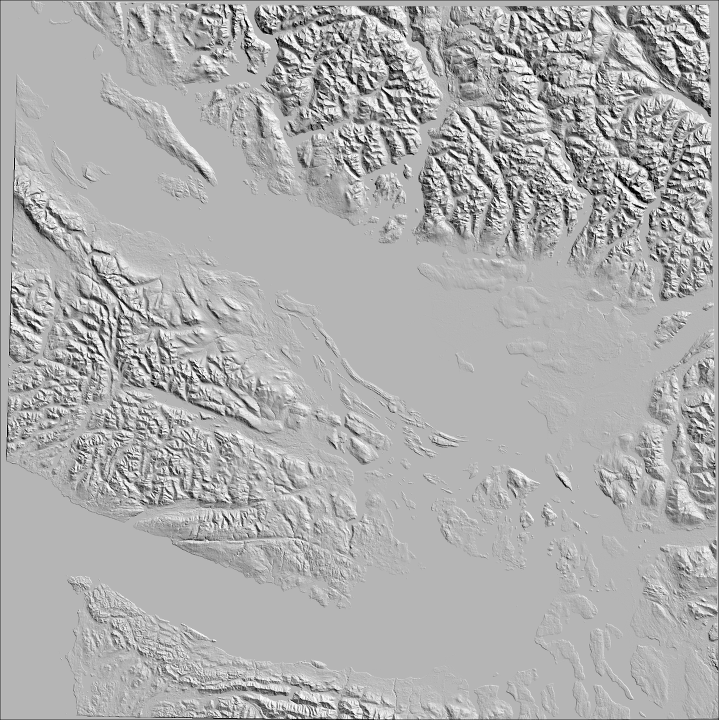

In [44]:
!! gdaldem hillshade -q -az 45 -alt 45 warped.tif hillshade.tif

[]

Hypsometric Tinting
===============

Hillshading can also be combined with height information to aid interpretation of the topography. The technical name for the process of coloring a DEM based on  height is *hypsometric tinting*. The process is simple, with GDAL mapping colors to cell heights, using a provided color scheme. 

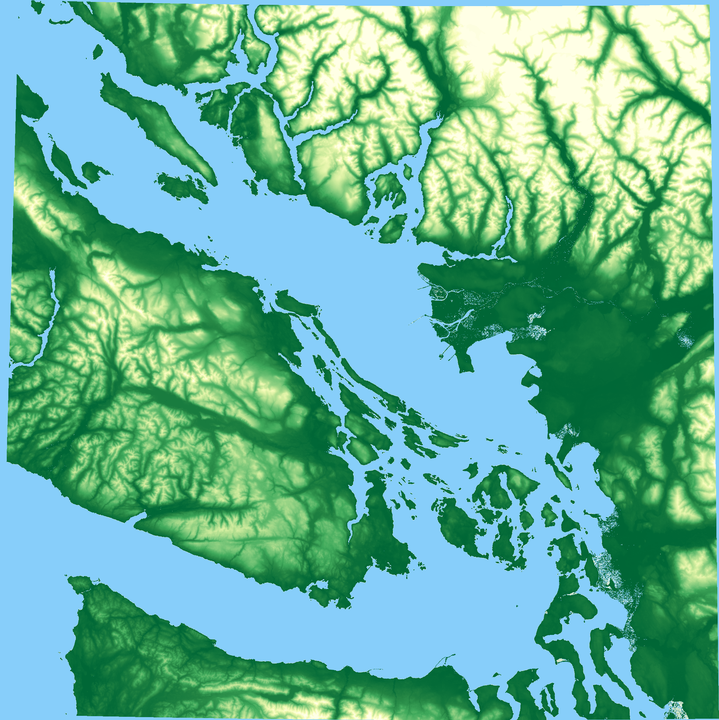

In [45]:
def createColorMapLUT(minHeight,maxHeight,cmap = cm.YlGn_r,numSteps=256):
    '''
    Create a colormap for visualisation
    '''
    f =open('color_relief.txt','w')
    f.write('-0.1,135,206,250 \n')
    f.write('0.1,135,206,250 \n')
    
    for i in range(0,numSteps):
        r,g,b,a= cmap(i/float(numSteps))
        height = minHeight + (maxHeight-minHeight)*(i/numSteps)
        f.write(str(height)+','+str(int(255*r))+','+str(int(255*g))+','+str(int(255*b))+'\n')
    f.write(str(-1)+','+str(int(255*r))+','+str(int(255*g))+','+str(int(255*b))+'\n')
    

createColorMapLUT(minHeight=10,maxHeight=2658)

In [46]:
!! gdaldem color-relief -q warped.tif color_relief.txt color_relief.tif

[]

Slope Shading
===============


Another technique for visualizing terrain is slopeshading. While hypsometric tinting assigns colors to cells based on elevation, slope shading assigns colors to pixels based on the slope (0º to 90º). In this case, white (255,255,255) is assigned to slopes of 0º and black (0,0,0) is assigned to slopes of 90º, with varying shades of grey for slopes in-between. 

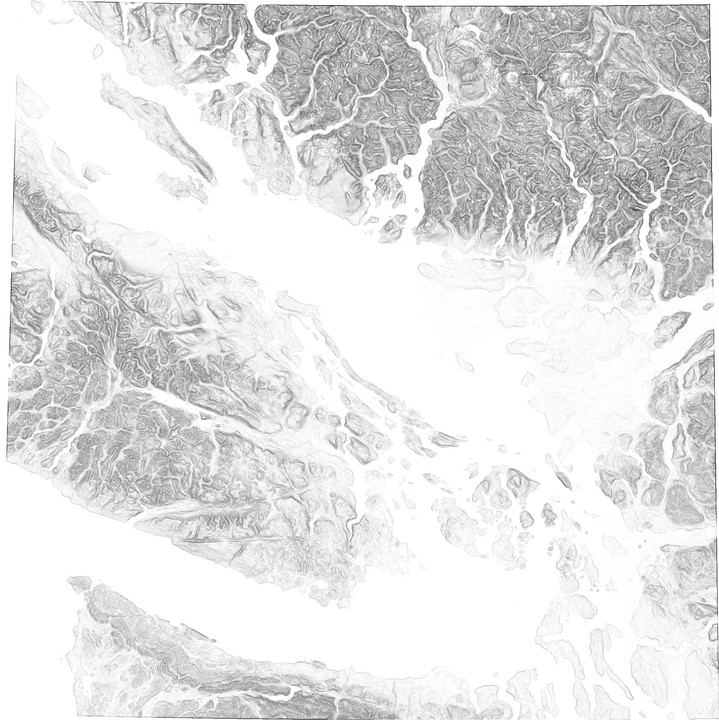

This color scheme is encoded in a txt file for gdaldem as follows: 


In [47]:
f = open('color_slope.txt','w')
f.write('0 255 255 255\n')
f.write('90 0 0 0\n')
f.close()

The computation of the slope shaded dem takes place over two steps. 

1. The slope of each cell is computed
2. A shade of grey is assigned to each cell depending on the slope.


In [48]:
!! gdaldem slope -q warped.tif slope.tif
!! gdaldem color-relief -q slope.tif color_slope.txt slopeshade.tif

[]

Layer Merging
===============

The final step in producing the final product is to merge the 3 different created images. The python Image Library (PIL) is a quick and dirty way to accomplish this task, with the 3 layers are merged using pixel by pixel multiplication. 

One important detail to note is that the pixel by pixel multiplication occurs in the RGB space. From a theoretical perspective, it's probably better that each pixel is first transformed to the Hue, Saturation, Value (HSV) color space, and the value is then multiplied by the hillshade and slope shade value, before being transformed back into the RGB color space. In practical terms however, the RGB space multiplication is a very reasonable approximation.

In one final tweak, the brightness of the output image is increased by 40%, to offset the average reduction in brightness caused by multiplying the layers together. 

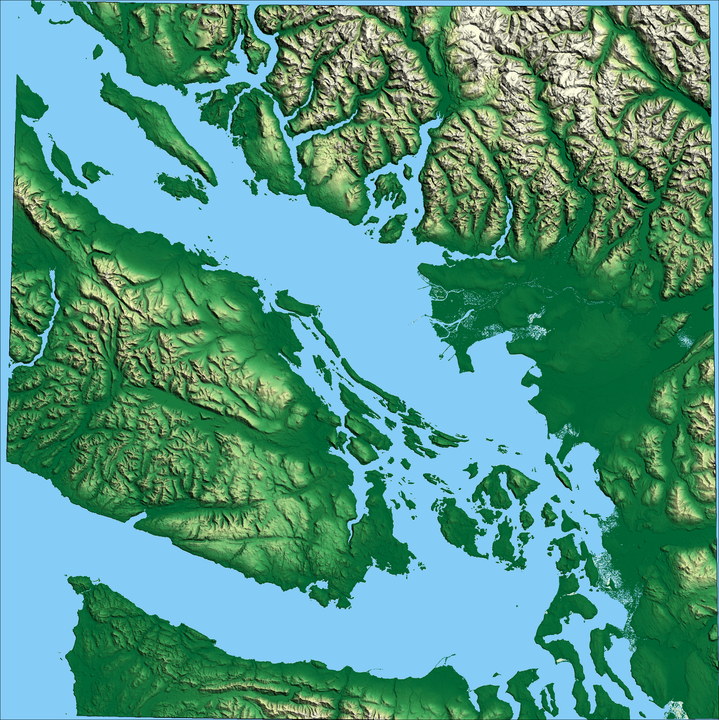

In [49]:
''' Merge components using Python Image Lib '''
slopeshade = Image.open("slopeshade.tif").convert('L')
hillshade = Image.open("hillshade.tif")
colorRelief = Image.open("color_relief.tif")

#Lets just fill in any gaps in the hillshading
ref = Image.new('L', slopeshade.size,180)
hillshade = ImageChops.lighter(hillshade,ref)

shading = ImageChops.multiply(slopeshade, hillshade).convert('RGB')
merged = ImageChops.multiply(shading,colorRelief)

''' Adjust the brightness to take into account the reduction caused by hillshading'''
enhancer = ImageEnhance.Brightness(merged)
img_enhanced = enhancer.enhance(1.4)
img_enhanced.save('Merged.png')

Further reading
===============
I found the following sources to be invaluable in compiling this post:

* [Creating color relief and slope shading](http://blog.thematicmapping.org/2012/06/creating-color-relief-and-slope-shading.html)
* [A workflow for creating beautiful relief shaded DEMs using gdal](http://linfiniti.com/2010/12/a-workflow-for-creating-beautiful-relief-shaded-dems-using-gdal/)
* [Shaded relief map in python](http://www.geophysique.be/2014/02/25/shaded-relief-map-in-python/)
* [Stamen Design](http://openterrain.tumblr.com/)